## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt
import models_vit

from pathlib import Path
import seaborn as sns

from dataset_classes.csi_sensing import CSISensingDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


### Define utils

In [2]:
def prepare_model(chkpt_dir, arch='vit_small_patch_16', pool='token'):
    # build model
    model = getattr(models_vit, arch)(global_pool=pool, num_classes=6)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    checkpoint_model = checkpoint['model']
    state_dict = model.state_dict()
    for k in ['head.weight', 'head.bias', 'pos_embed']:
        if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
            print(f"Removing key {k} from pretrained checkpoint")
            del checkpoint_model[k]
    checkpoint_model['patch_embed.proj.weight'] = checkpoint_model['patch_embed.proj.weight'].expand(-1, 3, -1, -1)
    msg = model.load_state_dict(checkpoint_model, strict=False)
    print(msg)
    return model

def display_confusion_mat(conf_mat: np.ndarray, class_labels, title='', normalize=True):
    if normalize:
        # Normalize the confusion matrix if specified
        row_sums = conf_mat.sum(axis=1, keepdims=True)
        row_sums[row_sums==0] = 1
        conf_mat = conf_mat / row_sums.astype(float)

    # Set up the figure
    plt.figure()

    # Create a heatmap using seaborn
    sns.heatmap(conf_mat, annot=True, fmt='.2f' if normalize else 'd', cmap='Reds',
                xticklabels=class_labels, yticklabels=class_labels)

    # Configure plot labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{title}')
    # plt.savefig(f"{title}.png", dpi=800)
    # Display the plot
    plt.show()

### Load a pre-trained MAE model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
chkpt_dir = Path('../checkpoints/sensing_small_75.pth')
model = prepare_model(chkpt_dir, arch='vit_small_patch16')
model = model.to(device)
model.eval()

<All keys matched successfully>


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

### Load dataset

In [4]:
dataset_test = CSISensingDataset('../../datasets/NTU-Fi_HAR/test')

### Confusion Matrices

Plotting: 100%|██████████| 17/17 [00:04<00:00,  3.86batch/s]


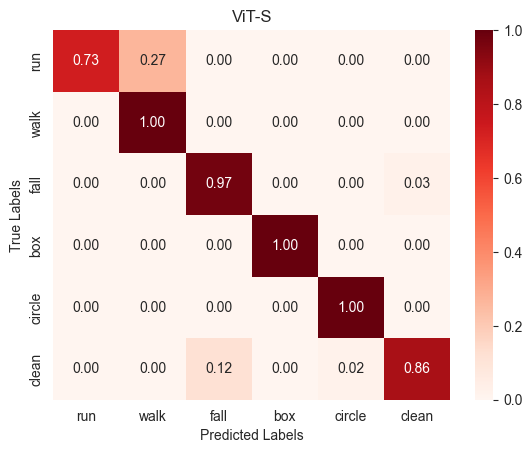

In [6]:
test_loader = DataLoader(dataset_test, batch_size=16)

conf_mat = np.zeros((6, 6))
with torch.no_grad():
    with tqdm(test_loader, desc='Plotting', unit='batch') as pbar:
        for samples, targets in pbar:
            samples = samples.to(device)
            outputs = model(samples).argmax(dim=-1).detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            conf_mat += confusion_matrix(outputs, targets, labels=range(6))
            
display_confusion_mat(conf_mat, ['run', 'walk', 'fall', 'box', 'circle', 'clean'], normalize=True, title='ViT-S')